In [1]:
# this cell imports the libraries or packages that you can use during this assignment
# you are not allowed to import additional libraries or packages

from helpers import *
import os
import itertools
import numpy as np
import pandas as pd

# Machine Learning and Decomposition
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import skfuzzy as fuzz

# Statistical tools
from scipy.stats import multivariate_normal
from scipy import linalg

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap, LogNorm
import seaborn as sns

> **Important**
>
> Do not import any other packages or libraries than the ones already provided to you. You can only use the imported packages _after_ they have been imported.
>
> Write your code between the `BEGIN_TODO` and `END_TODO` markers. Do not change these markers.
>
> Restart your notebook and run all cells before submission.

# Assignment 1a

## Introduction
In this assignment you will carry on data collection and preprocessing tasks, After collecting and preprocessing sensor recording, you will extract a set of features which you will use for creating the biking lane detector in assignment 1b.

This assignment is split into 4 parts. Parts 1-3 encompass the collection, preprocessing and feature extraction of sensor recordings. In part 4 you will employ PCA and ICA for data compression.

### Learning goals
After this assignment you can
- collect data according to a protocol;
- load and merge datasets;
- preprocess data;
- extract features from data;
- Perform data compression

## Part 1: Data collection

Collect the data according to the data collection protocol provided on Canvas.

## Part 2: Data cleaning and preprocessing
In this part you will be working on cleaning and preprocessing the overall data that each group have gathered for further analysis.


---
---
### Exercise 2.1: Read, merge and select data
Place your recordings in folder titled Data, inside the folder, create two folders, Bumpy folder and smooth folder, Load one of your individuals recordings from either folders in a Pandas DataFrame called `data`. You may want to have a look at the `pd.merge_asof` function to combine the recordings of the different sensors. Make sure that the `data` dataframe does not contain any `NaN`'s or empty fields as a result of different sampling frequencies. Any columns/recordings that you will not be using in your experiment should be removed from `data` (except for the `seconds_elapsed` column). Also remove duplicate colums. In the end your dataframe should have an indexing column, a column called `seconds_elapsed`, followed by the columns corresponding to the measurements.

In [9]:
#// BEGIN_TODO  Read, merge and select data

root_dir = os.path.dirname(os.path.abspath('__file__'))

def recording_path_list(lane_condition, root_dir):
    '''
    Returns the directory path for recording of each lane condition
    '''
    dir = os.path.join(root_dir, 'Data', lane_condition)
    data_paths = [os.path.join(dir, d) for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]    
    return data_paths

def load_cycling_data(lane_condition, record_num, sensors):
    '''
    Load data as a 2D list (row: recording, column: sensor)
    '''
    dfs = []
    data_paths = recording_path_list(lane_condition, root_dir)
    for i in range(record_num):
        df_record = []        
        for sensor in sensors:            
            path = os.path.join(data_paths[i], sensor + '.csv')
            df = pd.read_csv(path)
            df_record.append(df)
        dfs.append(df_record)
    return dfs

record_num = 1
sensors = ['Accelerometer', 'Gravity', 'Gyroscope']
dfs = load_cycling_data('Smooth', record_num, sensors)

accelerometer, gravity, gyroscope = dfs[0][0], dfs[0][1], dfs[0][2]

# remove time column
accelerometer.drop(columns='time', inplace=True)
gravity.drop(columns='time', inplace=True)
gyroscope.drop(columns='time', inplace=True)

# suffix the column name
gyroscope.rename(columns={'z':'z_gyroscope', 'y':'y_gyroscope', 'x':'x_gyroscope'}, inplace=True)

# merge data from three sensors
data = pd.merge_asof(accelerometer, gravity, on='seconds_elapsed', suffixes=('_accelerometer', '_gravity'))
data = pd.merge_asof(data, gyroscope, on='seconds_elapsed')

# drop NaN and duplicates
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

#// END_TODO 

In [10]:
data.shape

(3498, 10)

In [11]:
data.head()

,seconds_elapsed,z_accelerometer,y_accelerometer,x_accelerometer,z_gravity,y_gravity,x_gravity,z_gyroscope,y_gyroscope,x_gyroscope
0,0.025851,1.455184,-0.122007,-0.600994,-8.306641,-5.123689,-0.958080,0.117354,-1.909172,0.095624
1,0.035846,0.988163,0.075503,-0.834434,-8.286438,-5.126819,-1.105019,0.008036,-1.494072,0.013766
2,0.045843,0.526679,0.601984,-1.077192,-8.272071,-5.128073,-1.202537,-0.090236,-0.918243,0.008208
3,0.055839,0.247682,0.166312,-0.625316,-8.262272,-5.129492,-1.262363,-0.023133,-0.685370,0.000225
4,0.065834,0.688338,-0.215275,-0.230927,-8.253416,-5.126788,-1.329494,0.083277,-0.859246,-0.058152


### End of exercise 2.1
---
---

In order to restrict our focus to bumpy lane detection, we would like to trim the recorded segment. In this way we can remove the movements corresponding to starting and stopping the sensor logger app. 

---
---
### Exercise 2.2: Trim data
Remove the first and last 5 seconds of the recordings for this purpose and save this trimmed data frame to `data_trimmed`. Make sure that your code works for a data frame containing an arbitrary number of columns.

In [14]:
#// BEGIN_TODO Trim data

start_time = data['seconds_elapsed'].min() + 5
end_time = data['seconds_elapsed'].max() - 5
trim_target = data[(data['seconds_elapsed'] < start_time) | (data['seconds_elapsed'] > end_time)]
data_trimmed = data.drop(trim_target.index)

#// END_TODO 

In [15]:
data_trimmed.shape

(2496, 10)

In [16]:
data_trimmed.head()

,seconds_elapsed,z_accelerometer,y_accelerometer,x_accelerometer,z_gravity,y_gravity,x_gravity,z_gyroscope,y_gyroscope,x_gyroscope
501,5.033868,0.059676,-0.072753,-0.777055,3.241629,8.340380,4.012519,0.055464,0.244147,0.044604
502,5.043864,-0.016435,0.031807,-0.640125,3.247110,8.340266,4.008317,0.070141,0.328903,0.100629
503,5.053860,-0.033935,0.198564,-0.438162,3.251143,8.341402,4.002679,0.076842,0.390893,0.149129
504,5.063856,0.051906,0.383031,-0.221380,3.253888,8.343685,3.995690,0.080933,0.436818,0.181900
505,5.073852,0.220029,0.560360,0.003980,3.255604,8.346669,3.988052,0.078588,0.440728,0.197404


### End of exercise 2.2
---
---

---
---
### Exercise 2.3: Normalize recordings
For improved processing, the recordings should be normalized. Normalize the recordings by subtracting its mean and by then dividing by its standard deviation. Perform this normalization for each column individually. Save your normalized data in the the data frame `data_norm`.

In [19]:
#// BEGIN_TODO Normalize recordings

data_norm = (data_trimmed - data_trimmed.mean(axis=0)) / data_trimmed.std(axis=0)
data_norm['seconds_elapsed'] = data_trimmed['seconds_elapsed']

#// END_TODO 

In [20]:
data_norm.shape

(2496, 10)

In [21]:
data_norm.head()

,seconds_elapsed,z_accelerometer,y_accelerometer,x_accelerometer,z_gravity,y_gravity,x_gravity,z_gyroscope,y_gyroscope,x_gyroscope
501,5.033868,0.225077,-0.159105,-1.419400,0.396846,-0.450610,0.249882,0.403297,0.561455,0.166934
502,5.043864,0.086381,0.059817,-1.148607,0.412158,-0.451363,0.230609,0.532001,0.765281,0.417808
503,5.053860,0.054490,0.408965,-0.749205,0.423425,-0.443822,0.204746,0.590763,0.914358,0.634986
504,5.063856,0.210918,0.795192,-0.320495,0.431094,-0.428663,0.172684,0.626638,1.024799,0.781734
505,5.073852,0.517287,1.166474,0.125179,0.435888,-0.408854,0.137644,0.606076,1.034204,0.851155


### End of exercise 2.3
---
---

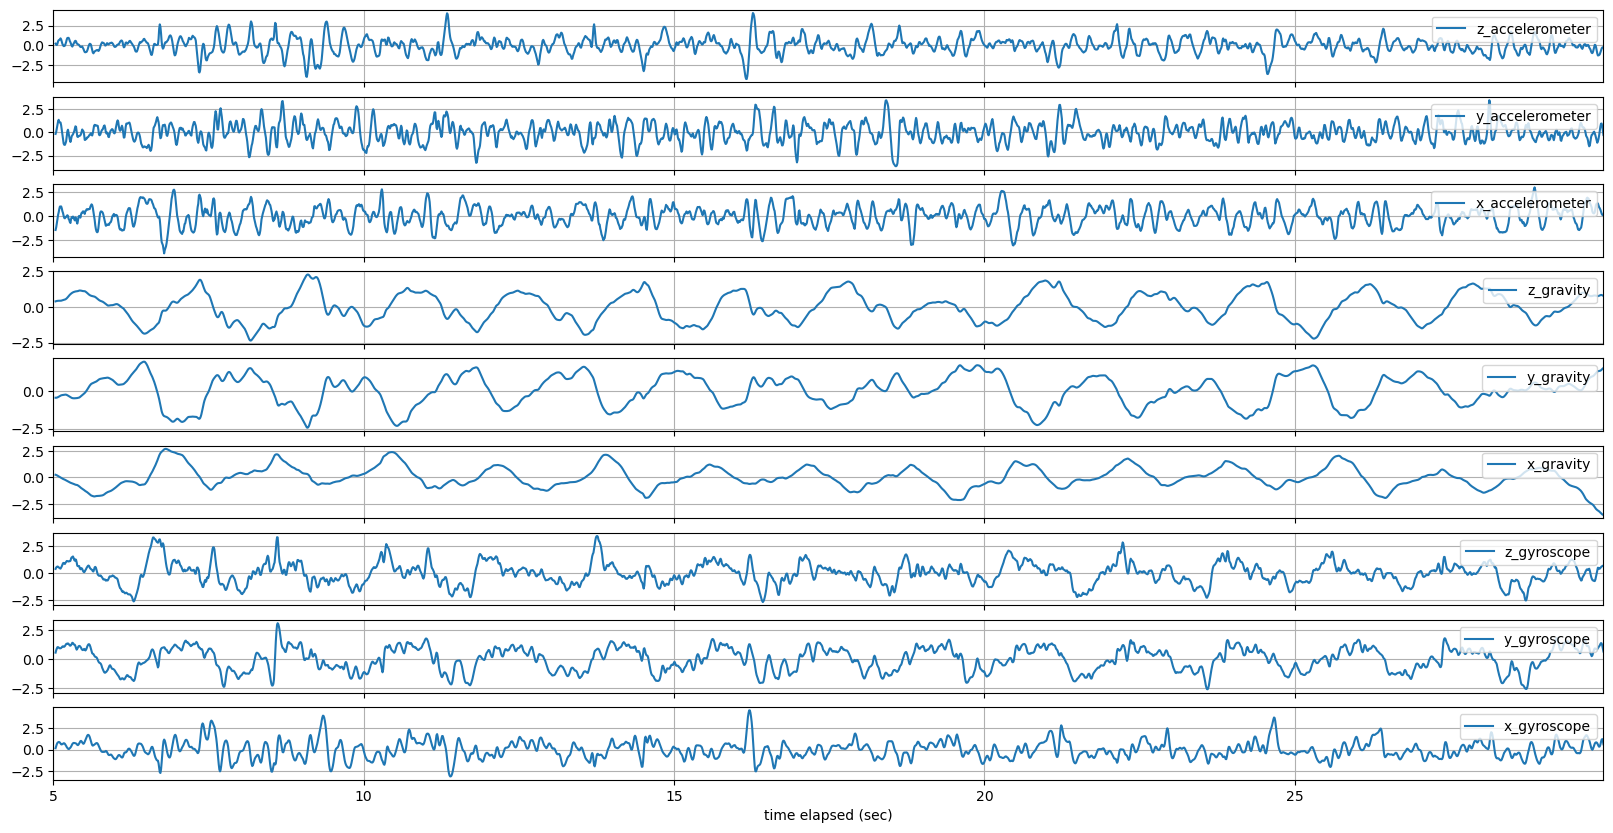

In [23]:
# plot recordings
ex2_plot_data(data_norm)

## Part 3: Feature extraction
The current data is not yet suited for building the detector. Based on the measurements at a specific point of time, it is difficult to determine whether the bike lane is smooth or bumpy. Instead, it would be more appropriate to perform the detection over _segments_ of time. In this part you will extract features that will be used for the detection. First all collected datasets will be processed.

---
---
### Exercise 3.1: Merge all datasets
Before starting the feature extraction, merge all the preprocessed datasets obtained in the protocol. You will need to load all recording, and again perform all preprocessing steps of Part 2 for the individual recordings. Make sure your code adheres to proper coding standards (make it look nice, don't copy part 2 15 times). Save your merged data in the the data frame `data_merged`, in addition, save merged data of bumpy lanes as `data_bumpy` and data of smooth lanes as `data_smooth`.

In [26]:
#// BEGIN_TODO Normalize recordings
       
class CyclingDataMerge():
    def __init__(self, df_list, sensor_list, on_label):
        self.dfs = df_list
        self.sensors = sensor_list
        self.on = on_label
        self.data_merged = pd.DataFrame()

    def drop_redundant_cols(self, col_redundant):
        for df in self.dfs:            
            df.drop(columns=col_redundant, inplace=True)
    
    def suffix_col_name(self, df, sensor, col_unchanged):
        new_name_dic = {}
        for col in df.columns:
            if col != col_unchanged:
                new_name_dic[col] = col + '_' + sensor.lower()
        return new_name_dic
    
    def merge_cycling_data(self):
        for i in range(len(self.dfs)):
            df = self.dfs[i]
            new_col_name = self.suffix_col_name(df, self.sensors[i], self.on)
            df.rename(columns=new_col_name, inplace=True)
            
        self.data_merged = self.dfs[0]
        for i in range(len(self.dfs)-1):
            self.data_merged = pd.merge_asof(self.data_merged, self.dfs[i+1], on=self.on)

    def get_data_merged(self):
        return self.data_merged

class CyclingDataPreprocess:
    def __init__(self, df):
        if isinstance(df, pd.DataFrame):            
            self.data = df
            self.data_trimmed =  self.data_norm = pd.DataFrame()
            self.mean_std = np.zeros((df.shape[0]))
        else:
            raise ValueError('This is not a data frame')
            
    def clean(self):                   
        self.data.dropna(inplace=True)
        self.data.drop_duplicates(inplace=True)        

    def trim(self, col='seconds_elapsed', sec_to_trim=5):
        start_time = self.data[col].min() + sec_to_trim
        end_time = self.data[col].max() - sec_to_trim
        trim_target = self.data[(self.data[col] < start_time) | (self.data[col] > end_time)]
        self.data_trimmed = self.data.drop(trim_target.index)        

    def normalize(self, col_list):
        self.data_norm = self.data_trimmed.copy()
        c = self.data_trimmed[col_list]
        self.data_norm[col_list] = (c - c.mean(axis=0)) / c.std(axis=0)            
        
    def get_data_normalized(self):
        return self.data_norm
    
sensors = ['Accelerometer', 'Gravity', 'Gyroscope']
on_label = 'seconds_elapsed'
col_redundant = ['time']
record_num = 15  # number of recordings for each lane condition

def get_data_per_lane_condition(lane_condition, record_num, senors, on_label, col_redundant):
    '''
    Get all data for the given lane condition, preprocess them and then merge them into a dataframe
    '''
    assert record_num <= len(recording_path_list(lane_condition, root_dir))
    dfs = load_cycling_data(lane_condition, record_num, sensors)
    
    for record_index in range(record_num):
        # merge data from the one recording
        merge = CyclingDataMerge(dfs[record_index],sensors,on_label)
        merge.drop_redundant_cols(col_redundant)
        merge.merge_cycling_data()
        data = merge.get_data_merged()
    
        preprocess = CyclingDataPreprocess(data)
        preprocess.clean()
        preprocess.trim()
        col_to_normalize = [col for col in data.columns if col != on_label]
        preprocess.normalize(col_to_normalize)
        dfs[record_index] = preprocess.get_data_normalized()
        
    data_merged = pd.concat(dfs, axis=0, ignore_index=True)
    
    return data_merged

data_smooth = get_data_per_lane_condition('Smooth', record_num, sensors, on_label, col_redundant)
data_bumpy = get_data_per_lane_condition('Bumpy', record_num, sensors, on_label, col_redundant)
data_merged = pd.concat([data_smooth, data_bumpy], axis=0, ignore_index=True)

#// END_TODO 

In [27]:
data_merged.shape

(97613, 10)

In [28]:
data_bumpy.shape

(50690, 10)

In [29]:
data_smooth.shape

(46923, 10)

In [30]:
data_merged.head()

,seconds_elapsed,z_accelerometer,y_accelerometer,x_accelerometer,z_gravity,y_gravity,x_gravity,z_gyroscope,y_gyroscope,x_gyroscope
0,5.033868,0.225077,-0.159105,-1.419400,0.396846,-0.450610,0.249882,0.403297,0.561455,0.166934
1,5.043864,0.086381,0.059817,-1.148607,0.412158,-0.451363,0.230609,0.532001,0.765281,0.417808
2,5.053860,0.054490,0.408965,-0.749205,0.423425,-0.443822,0.204746,0.590763,0.914358,0.634986
3,5.063856,0.210918,0.795192,-0.320495,0.431094,-0.428663,0.172684,0.626638,1.024799,0.781734
4,5.073852,0.517287,1.166474,0.125179,0.435888,-0.408854,0.137644,0.606076,1.034204,0.851155


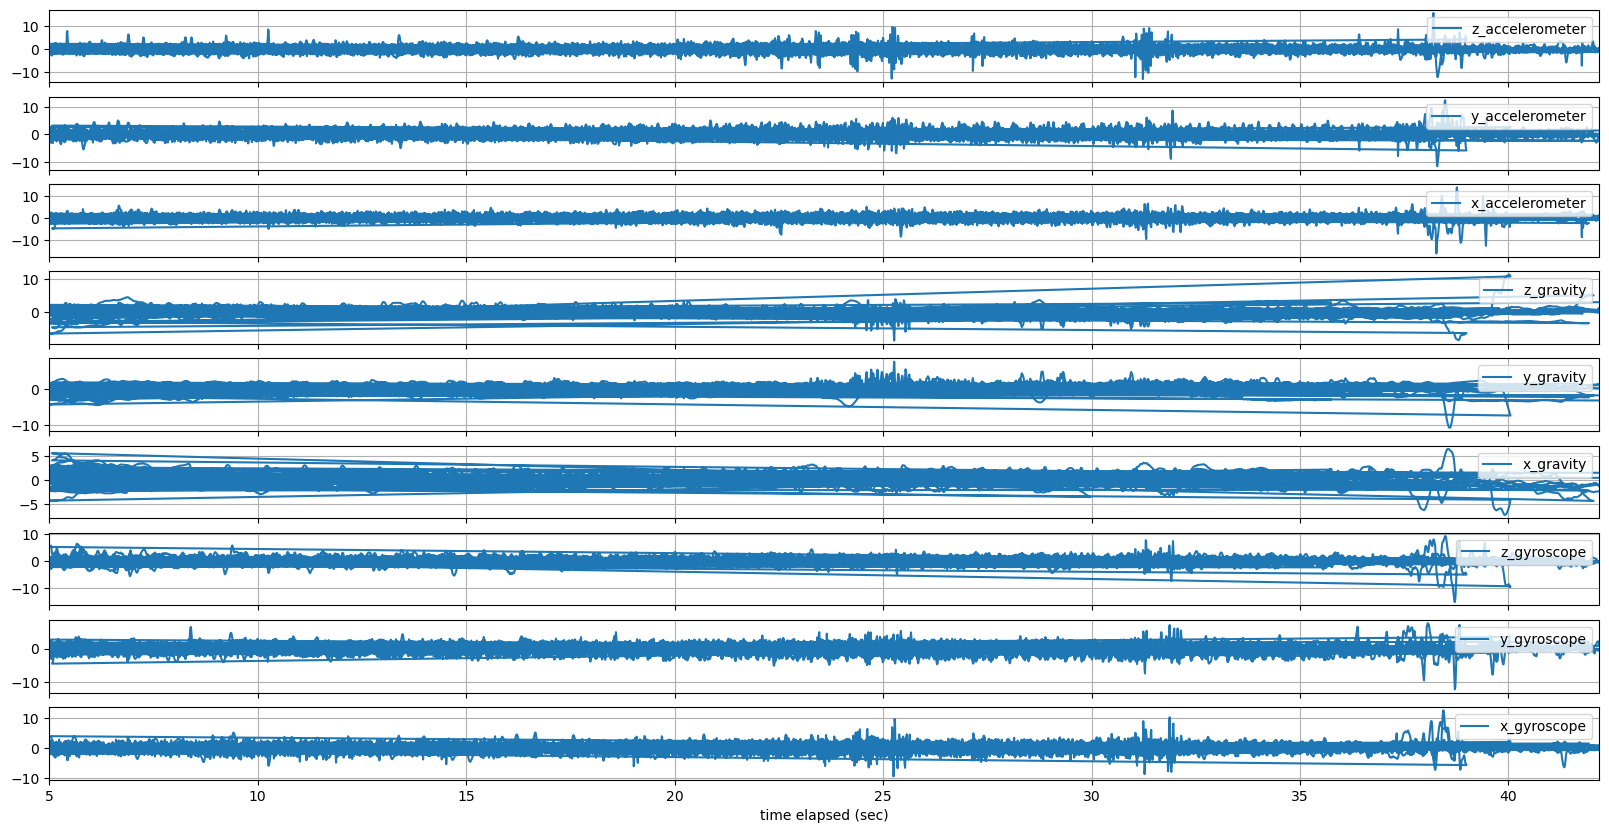

In [31]:
# plot recordings of data_merged
ex2_plot_data(data_merged)

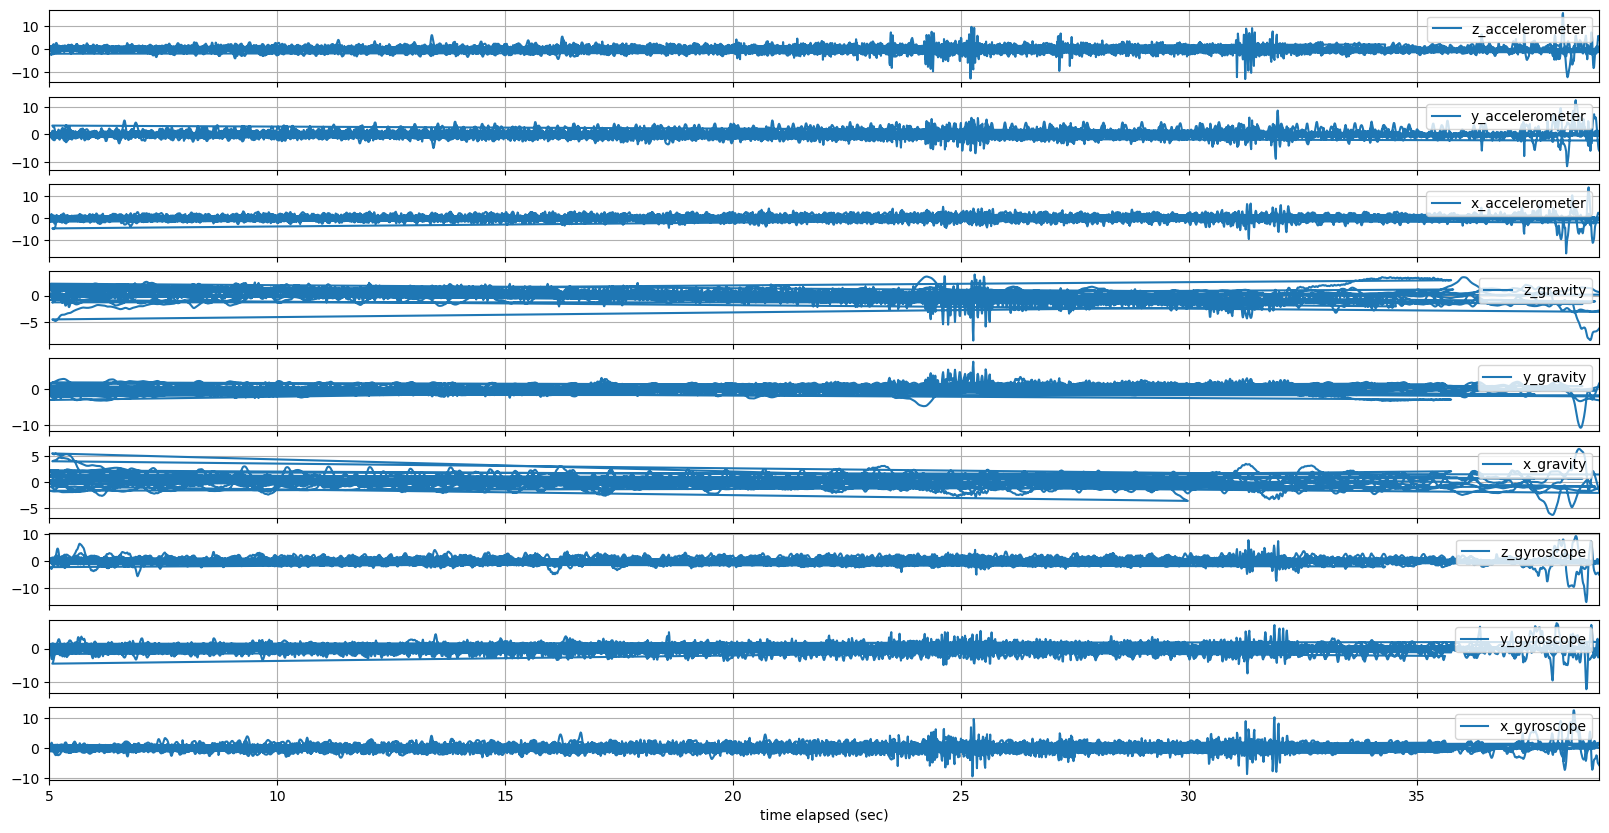

In [32]:
# plot recordings of data_smooth
ex2_plot_data(data_smooth)

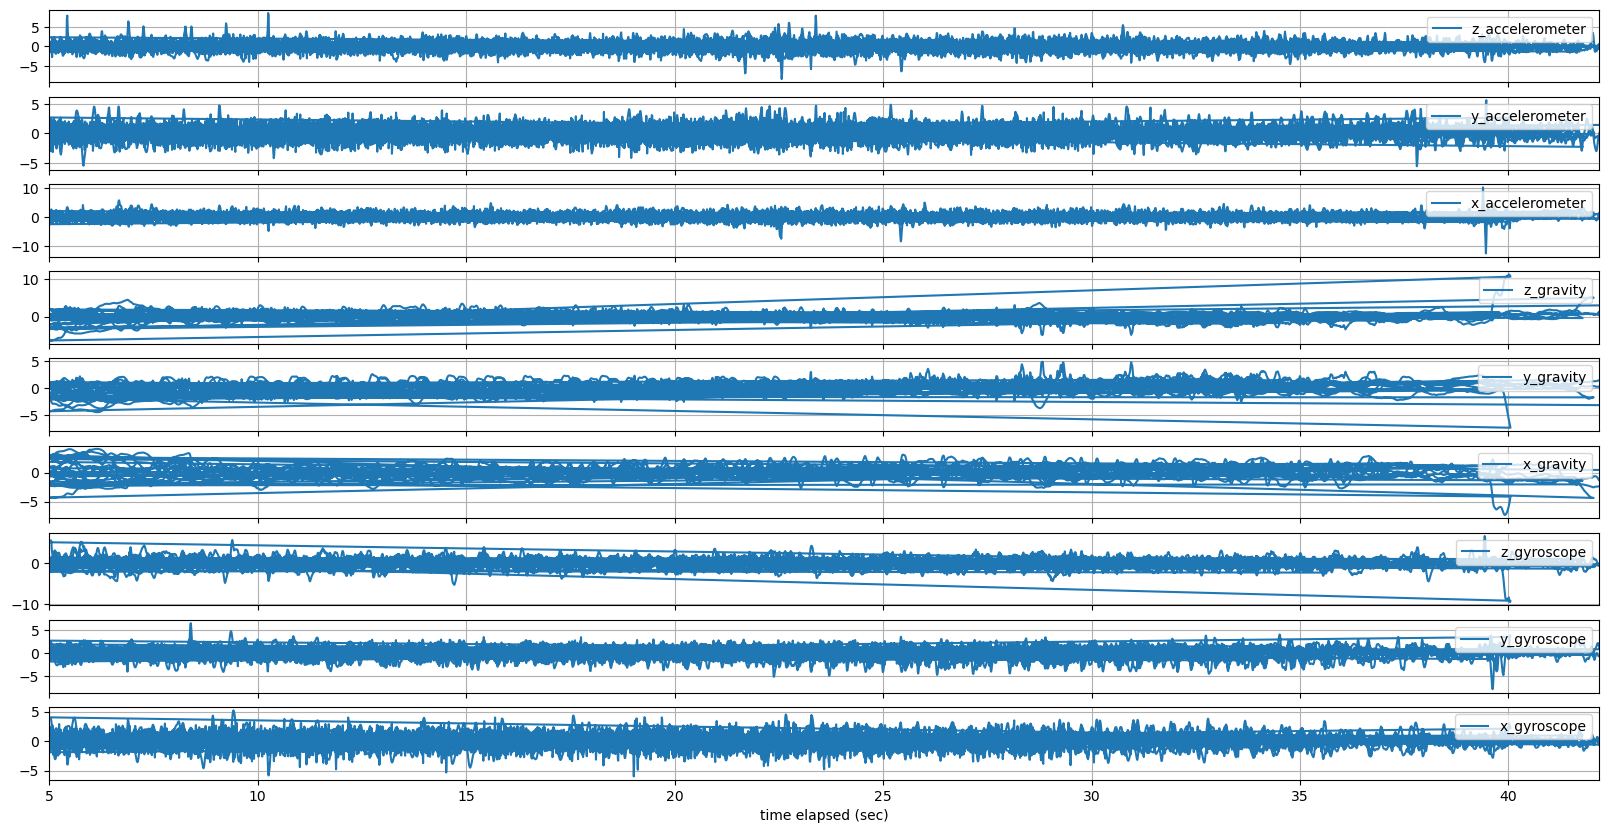

In [33]:
# plot recordings of data_bumpy
ex2_plot_data(data_bumpy)

### End of exercise 3.1
---
---

---
---
### Exercise 3.2: Convert dataframe to matrix
In order to extract features from the recordings, convert the dataframe `data_merged` to a Numpy matrix called `mat_merged`. The matrix should have dimensions (_nr of time points_, _nr or different recordings_). Make sure that you remove the _seconds_elapsed_ column, as this does not yield any useful information for the ;ane detector.

In [36]:
#// BEGIN_TODO  Convert to matrix

mat_merged = data_merged.drop(columns= ['seconds_elapsed']).to_numpy()

#// END_TODO 

### End of exercise 3.2
---
---

Now that the dataframe has been converted to a matrix, it can be split into different overlapping segments, of which we can extract features.

As a starting point we will specify features as the mean value of a segment, its standard deviation, its minimum and its maximum.

---
---
### Exercise 3.3: Processing segments
Create a function `Y = process_segment(mat, fun, L, K)` that processes time segments of your matrix. The argument `fun` specifies the operation to be performed on the segment and its value comes from the set `["mean", "std", "minimum", "maximum"]`. `L` specifies the segment length and `K` specifies the number of samples overlap between segments. The function should return a matrix `Y` with dimensions (_nr of segments_, _nr of different recordings_).

In [40]:
#// BEGIN_TODO Process segments

def process_segment(mat, fun, L, K):
    if K >= L:
        raise ValueError('K should be less than L')
    row_num = mat.shape[0]
    start, end =  0, L    
    segs = []
    while end <= row_num:               
        seg = mat[start:end]
        segs.append(seg)       
        start += L - K
        end = start + L

    if fun == 'mean':
        mp = map(lambda x:np.mean(x, axis=0, keepdims=True), segs)
    elif fun == 'std':
        mp = map(lambda x:np.std(x, axis=0, keepdims=True), segs)
    elif fun == 'minimum':
        mp = map(lambda x:np.min(x, axis=0, keepdims=True), segs)
    elif fun == 'maximum':
        mp = map(lambda x:np.max(x, axis=0, keepdims=True), segs)
    else:
        raise ValueError('fun should come from ["mean", "std", "minimum", "maximum"]')

    return np.concatenate(tuple(mp),axis=0)

#// END_TODO 

In [41]:
Y_mean_1 = process_segment(mat_merged, "mean", 20, 10)
Y_std_1 = process_segment(mat_merged, "std", 20, 10)
Y_minimum_1 = process_segment(mat_merged, "minimum", 20, 10)
Y_maximum_1 = process_segment(mat_merged, "maximum", 20, 10)

### End of exercise 3.3
---
---

---
---
### Exercise 3.4: Concatenate features
Now that you have computed some features of the recordings, it becomes necessary to combine them. Create the matrix `combined_features` which concatenates the above results along the appropriate axis.


In [44]:
#// BEGIN_TODO Concatenate features

combined_features = np.concatenate((Y_mean_1, Y_std_1, Y_minimum_1, Y_maximum_1), axis=1)

#// END_TODO 

### End of exercise 3.4
---
---

### Exercise 3.5: preprocessing smooth and bumpy dataframes
perform the same preprocessing steps on your smooth and bumpy dataframe. By the end of the exercise you should output two additional matrices; `smooth_features` and `combined_features`

In [47]:
#// BEGIN_TODO Concatenate features

mat_smooth = data_smooth.drop(columns= ['seconds_elapsed']).to_numpy()
mat_bumpy = data_bumpy.drop(columns= ['seconds_elapsed']).to_numpy()
feature_name = ["mean", "std", "minimum", "maximum"]

def extract_features(mat, L, K, feature_name):
    features = []
    for f in feature_name:
        y = process_segment(mat, f, L, K)
        features.append(y)
    return tuple(features)

smooth_t = extract_features(mat_smooth, 20, 10, feature_name)
smooth_features = np.concatenate(smooth_t, axis=1)

bumpy_t = extract_features(mat_bumpy, 20, 10, feature_name)
bumpy_features = np.concatenate(bumpy_t, axis=1)

#// END_TODO 

In [48]:
print("Dimensions of combined features:", combined_features.shape)
print("Dimensions of smooth features:", smooth_features.shape)
print("Dimensions of bumpy features:", bumpy_features.shape)

Dimensions of combined features: (9760, 36)
Dimensions of smooth features: (4691, 36)
Dimensions of bumpy features: (5068, 36)


### End of exercise 3.5
---
---

## Part 4: Data Compression
In this part of the assignment you will implement the data compression techniques you have learned during the course.

## Part 4.1: Principal component analysis

Recorded data is often high-dimensional, leading to a large computational burden and limiting real-time data processing. Quite often we would therefore like to compress the data, such that it uses less memory. The creation of .zip-files on your computer is an example of data compression. In this part we will look at one method that achieves data compression, namely Principal component analysis (PCA). PCA is a useful technique for analyzing high-dimensional data, and compressing this data for storage or processing purposes. PCA aims to fit an orthogonal coordinate system to a dataset that best captures the variance or spread of the data. This approach is very closely related to the eigendecomposition of a matrix.

PCA aims to find the orthogonal directions of most variance of the dataset. Therefore it first computes the covariance matrix of the dataset, which can be estimated as
$$\Sigma = \mathrm{Cov}[{\bf{x}}] \approx \frac{1}{N-1} \sum_{n=1}^N ({\bf{x}}_n - \mathrm{E}[{\bf{x}}])({\bf{x}}_n - \mathrm{E}[{\bf{x}}])^\top,$$
where ${\bf{x}}_n$ is the $n$-th data sample and where $\mathrm{E}[{\bf{x}}]$ represents the expected value, or mean, which can be estimated as
$$\mathrm{E}[{\bf{x}}] \approx \frac{1}{N} \sum_{n=1}^N {\bf{x}}_n.$$
The covariance matrix captures the variances of the individual elements/features in ${\bf{x}}_n$ and the covariances between elements/features. 

Based on the obtained covariance matrix, you will perform an eigendecomposition. An eigenvalue decomposition finds a set of eigenvectors and corresponding eigenvalues. An eigenvector ${\bf{v}}$ and corresponding eigenvalue ${\lambda}$ of some square matrix $A$ satisfy the equation
$$A {\bf{v}} = \lambda {\bf{v}}.$$
In matrix notation, this can be written as
$$A Q = Q\Lambda,$$
where $Q$ is an orthonormal matrix where each column represents an eigenvector. Orthonormal refers to the individual eigenvectors being of unit length, and perpendicular to eachother. This matrix satisfies the useful properties $QQ^\top = Q^\top Q = I$ and $Q^\top = Q^{-1}$. $\Lambda$ is a diagonal matrix, whose diagonal contains the eigenvalues of $A$. The matrix $A$ can therefore be decomposed as 
$$A = Q\Lambda Q^\top$$

---
---
### Exercise 4.1: Compute eigenvalues and eigenvectors


Write a function `compute_eigen(X)` which computes the eigenvalues and eigenvectors of the covariance matrix of some toy dataset `X`. The dataset is a matrix of shape ($N\times M$), where $N$ denotes the number of data samples and $M$ the dimensionality of the features. The function should return a vector of length $M$ containing the eigenvalues and a matrix of shape ($M\times M$) containing the corresponding eigenvectors.

In [54]:
#// BEGIN_TODO Compute eigenvalues and eigenvectors

def compute_eigen(X):
    cov = np.cov(X.T)
    return np.linalg.eig(cov)
    
#// END_TODO 

(array([10.58176411,  1.04756589]),
 array([[ 0.85326718,  0.52147399],
        [-0.52147399,  0.85326718]]))

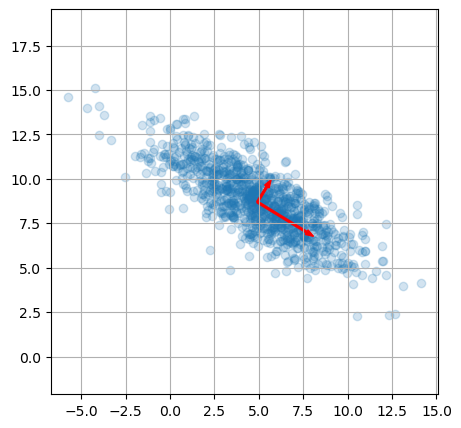

In [55]:
# generate data
X = ex11_generate_data()

# compute eigenvalues and eigenvectors
eigvals, eigvecs = compute_eigen(X)

# plot data
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], alpha=0.2)
plot_eigen(np.mean(X, axis=0), eigvals, eigvecs, plt.gca(), width=0.1, color="r")
plt.axis("equal")
plt.grid()

# print eigenvalues and eigenvectors
eigvals, eigvecs

Have a look at the computed eigenvalues, eigenvectors and the visualization and answer the questions below:
- In what direction does the first eigenvector point?
- How can the eigenvalue be interpreted?

`BEGIN_TODO Interpretation of eigenvalues and eigenvectors`

Answer: Along the direction the first eigenvector points, the feature values achieve the largest variance; eigenvalue can be interpreted as the vairance of data projected onto the 1D subspace(spaned by the corresponding eigen vector)


`END_TODO `

### End of exercise 4.1
---
---

With the computed eigendecomposition, the original dataset can be transformed such that its new mean coincides with the origin (0,0) and that the new eigenvectors specify Euclidean standard basis vectors (i.e. the new covariance matrix is diagonal). The first step can be obtained by subtracting the mean from the dataset. The origin-centered dataset $\tilde{X}$ now is centered in the origin and therefore the covariance matrix can be estimated as 
$$ \tilde{\Sigma} = \mathrm{Cov}[\tilde{\bf{x}}] \approx \frac{1}{N-1} \tilde{X}^\top \tilde{X}\qquad\qquad \text{if }\mathrm{E}[\tilde{{\bf{x}}}] = {\bf{0}}$$
with the corresponding eigendecomposition $\tilde{\Sigma} = \tilde{Q} \tilde{\Lambda} \tilde{Q}^\top$.

If we multiply $\tilde{X}$ with $\tilde{Q}$ to get the transformed dataset $Y=\tilde{X}\tilde{Q}$, we observe that the new covariance matrix becomes
$$\mathrm{Cov}[{\bf{y}}] \approx \frac{1}{N-1} Y^\top Y = \frac{1}{N-1}\tilde{Q}^\top \tilde{X}^\top \tilde{X} \tilde{Q} = \tilde{Q}^\top\tilde{\Sigma}\tilde{Q} = \tilde{Q}^\top\tilde{Q} \tilde{\Lambda} \tilde{Q}^\top\tilde{Q} = \tilde{\Lambda},$$
which is diagonal.



---
---
### Exercise 4.2: Data transformation

Write a function `transform_PCA(X, mean, eigvecs)` which translates some dataset `X` to be centered in the origin, and rotates it, such that its new covariance matrix is diagonal. $X$ is of shape ($N\times M$), where $N$ denotes the number of data samples and $M$ the dimensionality of the features. The function should return the transformed dataset of shape ($N\times M$). Also create the function `inversetransform_PCA(X, mean, eigvecs)` which performs the inverse transform.

In [62]:
#// BEGIN_TODO Transform data to PCA space

def transform_PCA(X, mean, eigvecs):
    return  (X - mean) @ eigvecs

#// END_TODO 

In [63]:
#// BEGIN_TODO Transform data back from PCA space

def inversetransform_PCA(X, mean, eigvecs):
    return X @ eigvecs.T + mean
    
#// END_TODO

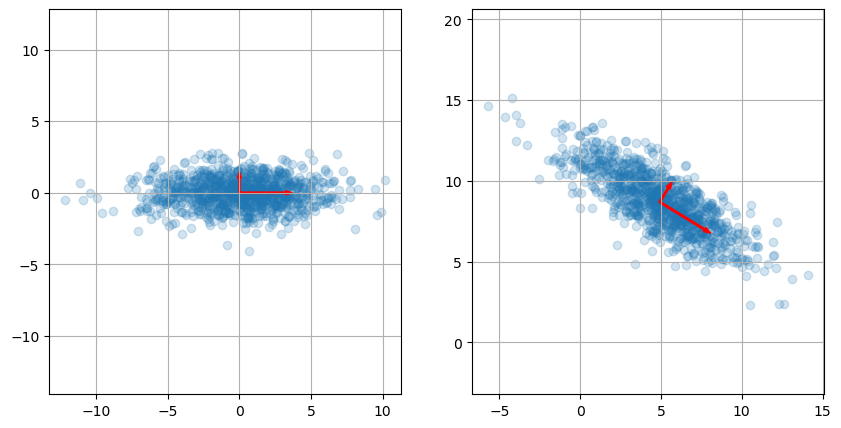

In [64]:
# transform data
m = np.mean(X, axis=0)
eigvals, eigvecs = compute_eigen(X)
Y = transform_PCA(X, m, eigvecs)
Z = inversetransform_PCA(Y, m, eigvecs)

# plot transformed data
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].scatter(Y[:,0], Y[:,1], alpha=0.2)
eigvalsY, eigvecsY = compute_eigen(Y)
plot_eigen(np.mean(Y, axis=0), eigvalsY, eigvecsY, ax[0], width=0.1, color="r")
ax[1].scatter(Z[:,0], Z[:,1], alpha=0.2)
eigvalsZ, eigvecsZ = compute_eigen(Z)
plot_eigen(np.mean(Z, axis=0), eigvalsZ, eigvecsZ, ax[1], width=0.1, color="r")
ax[0].axis("equal"), ax[1].axis("equal")
ax[0].grid(), ax[1].grid();

### End of exercise 4.2
---
---

So far PCA has only been discussed for a toy example. Let's now apply it to high-dimensional data. We will load a dataset containing 400 images of faces. These grayscale images are of size (64 $\times$ 64) and therefore contain 4096 pixels. In order to process the images, they have been flattened into vectors, which are appended to create a matrix containing 400 images. Below we have plotted the first 100 images:

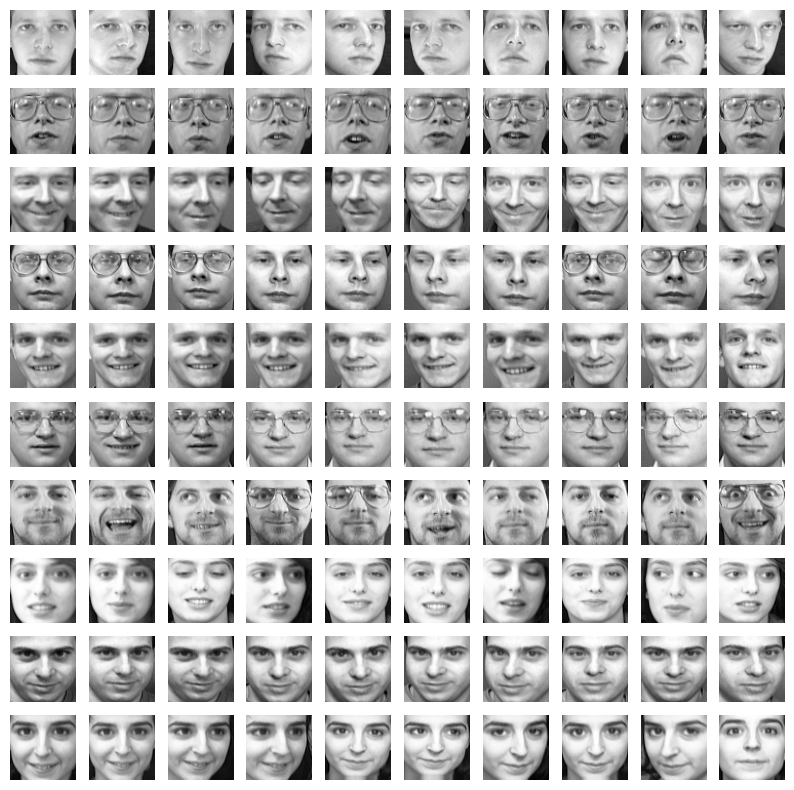

In [67]:
X = ex13_generate_data()
plot_faces(X)

---
---
### Exercise 4.3: Principal components analysis
Compute the eigenvalues and vectors of the faces dataset. Plot the first 350 eigenvalues with both a normal as log-scaling on the y-axis.

> Note: Since the dataset only contains 400 images, the covariance matrix of size (4096 $\times$ 4096) is not positive definite (although it should be in theory). Therefore the eigenvalues > 400 are basically useless, however, they are still computed as imaginary quantities. You can plot the real or absolute values of the eigenvalues.

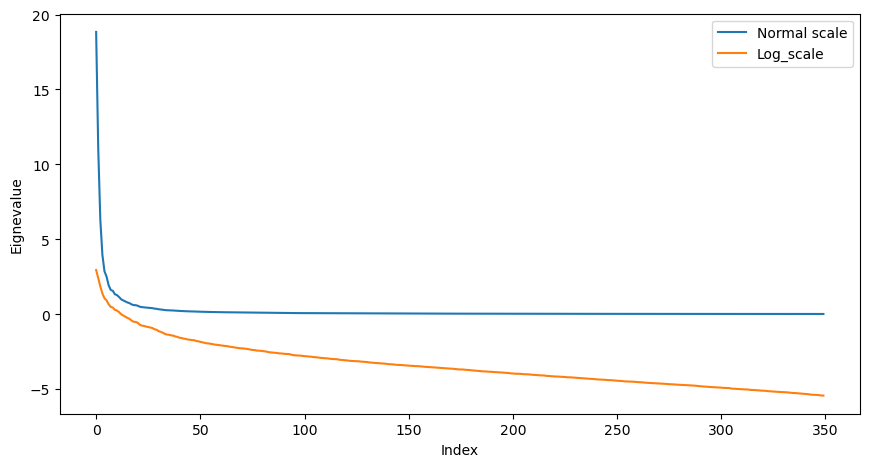

In [69]:
#// BEGIN_TODO Plot eigenvalues

eigvals, eigvecs = compute_eigen(X)
idx = eigvals.argsort()[::-1]
real_eigvals = np.real(eigvals[idx])[:350]
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([.1, .1, .8, .8])
ax.plot(real_eigvals, label='Normal scale')
ax.plot(np.log(real_eigvals), label='Log_scale')
ax.set_xlabel('Index')
ax.set_ylabel('Eignevalue')
ax.legend()

#// END_TODO 

Based on the created plots, what do you observe? How could this be useful for data compression?

`#// BEGIN_TODO  What do you observe?`  

After sorting the eigenvalues, the eigenvectors corresponding to the smaller eigenvalues represent directions carry very little infomation of the dataset. These components can be removed from the projection matrix during PCA.

`#// END_TODO`

### End of exercise 4.3
---
---

Now we will use PCA for data compression. Instead of performing the transform to the PCA space with the entire eigenvector matrix with shape (4096 $\times$ 4096), we only use the $K$ eigenvectors corresponding with the $K$ largest eigenvalues. 

---
---
### Exercise 4.4: Data compression
Compress the faces dataset using PCA in a matrix of shape (400 $\times$ $K$) and then decompress the data and plot the faces using the `plot_faces()` function. 

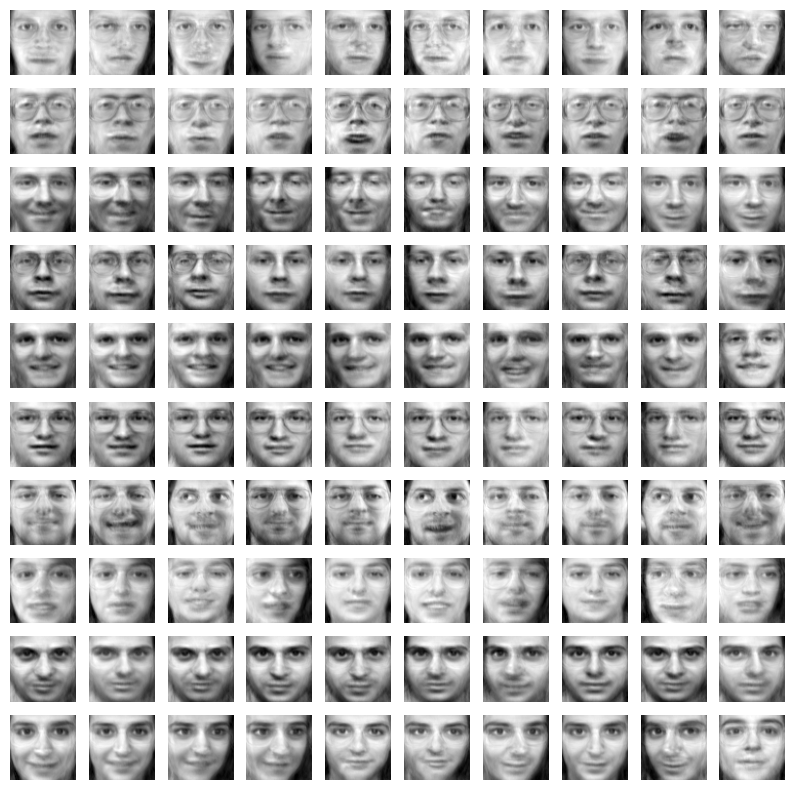

In [75]:
#// BEGIN_TODO Data compression

K = 50
mean = X.mean(axis=0)
eigvecs_k = eigvecs[:, idx[:K]]

Y = transform_PCA(X, mean, eigvecs_k)
Z = inversetransform_PCA(Y, mean, eigvecs_k)

plot_faces(Z)

#// END_TODO

Analyze the results. What do you observe if you change $K$?

`#// BEGIN_TODO What do you observe?`  
As K decreases, the pictures become increasingly blurry, which means more information of the original dataset get lost. Once K reaches a certain threshold, the image quality stabilizes and shows minimal difference compared to the original, indicating that most of the information is retained by those K components.


`#// END_TODO`

### End of exercise 4.4
---
---

---
---
### Exercise 4.5: PCA implementation on biking data
During this part you can make use of the sklearn (Scikit learn) package. This package offers some benefits over the handwritten clustering functions. These algorithms are numerically stable and better optimized to run on large data sets. choose 2 principal components for this exercise. Store the compressed data of combined_features as pca_combined, store the compressed data for smooth_features as pca_smooth, store the compressed data for bumpy features as pca_bumpy.

In [80]:
#// BEGIN_TODO PCA with sklearn

pca = PCA(n_components=2)
pca_combined = pca.fit_transform(combined_features)
pca_smooth = pca.fit_transform(smooth_features)
pca_bumpy = pca.fit_transform(bumpy_features)

#// END_TODO 

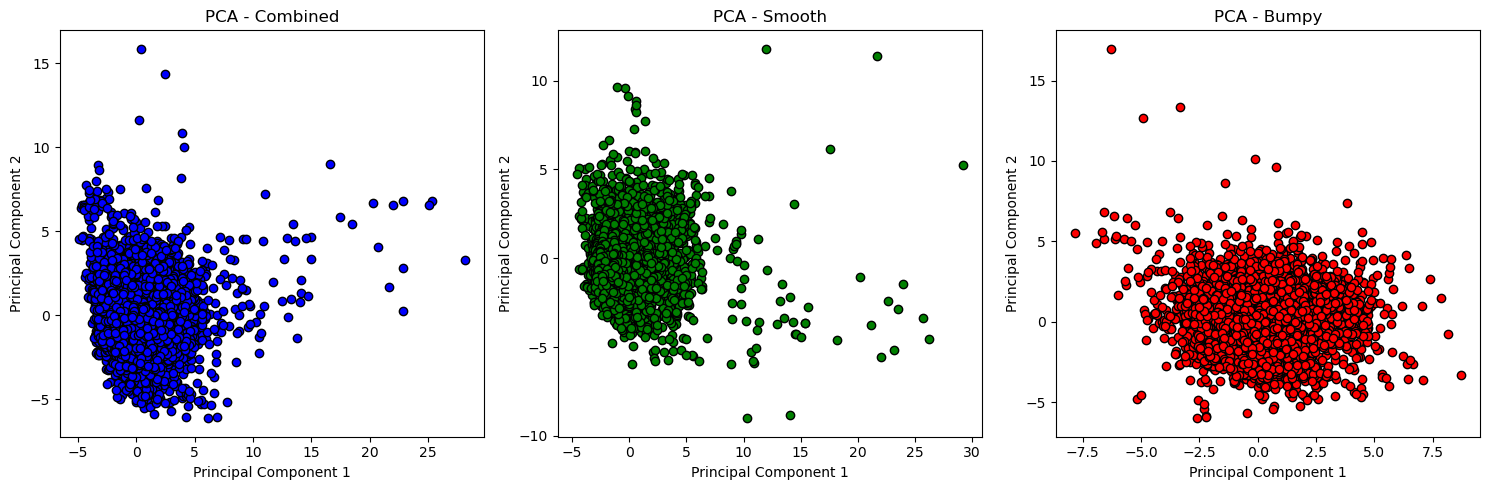

In [81]:

# Create a figure with 3 subplots in a single row
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot PCA for combined features
axs[0].scatter(pca_combined[:, 0], pca_combined[:, 1], c='blue', edgecolor='k')
axs[0].set_title('PCA - Combined')
axs[0].set_xlabel('Principal Component 1')
axs[0].set_ylabel('Principal Component 2')

# Plot PCA for smooth features
axs[1].scatter(pca_smooth[:, 0], pca_smooth[:, 1], c='green', edgecolor='k')
axs[1].set_title('PCA - Smooth')
axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')

# Plot PCA for bumpy features
axs[2].scatter(pca_bumpy[:, 0], pca_bumpy[:, 1], c='red', edgecolor='k')
axs[2].set_title('PCA - Bumpy')
axs[2].set_xlabel('Principal Component 1')
axs[2].set_ylabel('Principal Component 2')

# Adjust layout so plots don’t overlap
plt.tight_layout()

# Show the plots
plt.show()


Although we are choosing 2 components, how many principal components would you consider? Justify your answer quantitatively and qualitatively.

`#// BEGIN_TODO  PCA with sklearn/qualitative`  

Considering the complexity of the dataset and the potential loss of information, 5-10 components might be appropriate to capture the variability of the data.

`#// END_TODO`

In [84]:
#// BEGIN_TODO  PCA with sklearn/quantitative
pca_combined = PCA(n_components=0.9)
pca_combined_reduced = pca_combined.fit_transform(combined_features)

pca_smooth = PCA(n_components=0.9)
pca_smooth_reduced = pca_smooth.fit_transform(smooth_features)

pca_bumpy = PCA(n_components=0.9)
pca_bumpy_reduced = pca_bumpy.fit_transform(bumpy_features)

print(f'To retain 90% of the varience of the combined data, {pca_combined.n_components_} components should be chosen')
print(f'To retain 90% of the varience of the smooth data, {pca_smooth.n_components_} components should be chosen')
print(f'To retain 90% of the varience of the bumpy data, {pca_bumpy.n_components_} components should be chosen')
#// END_TODO


To retain 90% of the varience of the combined data, 12 components should be chosen
To retain 90% of the varience of the smooth data, 11 components should be chosen
To retain 90% of the varience of the bumpy data, 13 components should be chosen


### End of exercise 4.5
---
---

## Part 4.2: Independent component analysis

Another approach of finding the most important components in a dataset is independent component analysis (ICA). Below you will use it to analyze a toy data set.

---
---
### Exercise 4.6: Limitations PCA
Have a look at the dataset below. Would PCA be a good approach for finding the components of highest variance? Please motivate your answer.

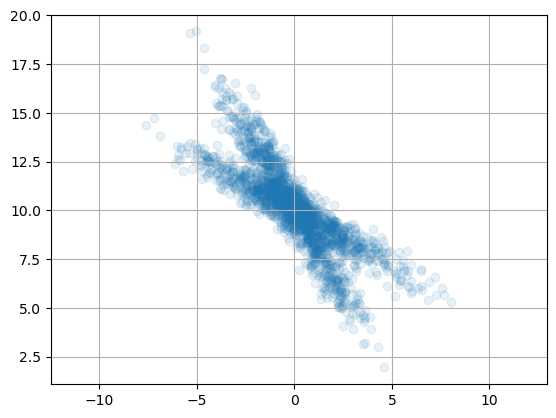

In [89]:
X = ex21_generate_data()
plt.scatter(X[:,0], X[:,1], alpha=0.1)
plt.grid(True)
plt.axis("equal");

`#// BEGIN_TODO Limitations PCA`  

No. After projection onto the PCA subspace, the features along different PCA axes are uncorrelated but not necessarily independent.

`#// END_TODO`

### End of exercise 4.6
---
---

> Note: From this moment onwards you can use the `FastICA` function from `sklearn`.

---
---
### Exercise 4.7: PCA versus ICA
Use the `PCA` and `FastICA` functions from `sklearn` to create the objects `pca_object` and `ica_object`, each with two components. Fit these objects to the dataset and transform the dataset. Save the transformed dataset into the variables `data_transformed_pca` and `data_transformed_ica`.

In [94]:
#// BEGIN_TODO PCA and ICA

pca_object = PCA(n_components=2)
data_transformed_pca = pca_object.fit_transform(X)

ica_object = FastICA(n_components=2, tol=0.05)
data_transformed_ica = ica_object.fit_transform(X)

#// END_TODO

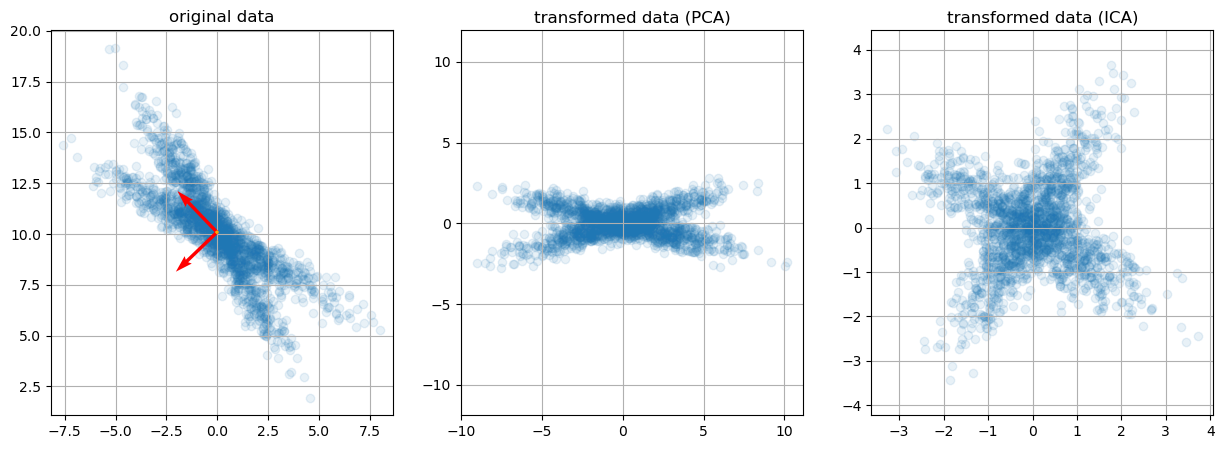

In [95]:
_, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].scatter(X[:,0], X[:,1], alpha=0.1)
ax[1].scatter(data_transformed_pca[:,0], data_transformed_pca[:,1], alpha=0.1)
ax[2].scatter(data_transformed_ica[:,0], data_transformed_ica[:,1], alpha=0.1)
plot_pca(ax[0], pca_object, np.mean(X, axis=0))
plot_ica(ax[0], ica_object, np.mean(X, axis=0))
ax[0].grid(True), ax[1].grid(True), ax[2].grid(True)
ax[0].axis('equal'), ax[1].axis('equal'), ax[2].axis('equal')
ax[0].set_title("original data"), ax[1].set_title("transformed data (PCA)"), ax[2].set_title("transformed data (ICA)");

Run your code a couple of times. What do you observe? Which method works best for this data set?

`#// BEGIN_TODO PCA versus ICA`  

The output of the ICA algorithm changes with each run, while the output of PCA remains same.
ICA works better as it identifies axes such that the data, when projected onto these axes, exhibit independence.

`#// END_TODO`

### End of exercise 4.7
---
---

> Make sure to restart this notebook and to rerun all cells before submission to check whether all code runs properly.

# End of Assignment 1a

---
---
---